<a href="https://colab.research.google.com/github/hardscrey/steam-user-clustering/blob/main/steam_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import zipfile
import os
import shutil
import json
import sqlite3
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

1. Загрузка и извлечение данных

In [ ]:
src_path = '/content/drive/MyDrive/Colab Notebooks/archive.zip'
dst_path = '/content/steam_profiles.zip'

shutil.copy(src_path, dst_path)


'/content/steam_profiles.zip'

In [ ]:
with zipfile.ZipFile('/content/steam_profiles.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/steam_data')

Копируем и распаковываем архив с профилями Steam

In [ ]:
db_path = '/content/steam_data/users'
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('accounts',)]


Просмотр содержания таблицы

In [ ]:
cursor.execute("PRAGMA table_info(accounts);")
for col in cursor.fetchall():
    print(col)

(0, 'steamID', 'INTEGER', 0, None, 1)
(1, 'games_used', 'BOOLEAN', 0, None, 0)
(2, 'friends_available', 'BOOLEAN', 0, None, 0)
(3, 'friends', 'JSONB', 0, None, 0)
(4, 'games', 'JSONB', 0, None, 0)


Просмотр содержания строки

In [ ]:
cursor.execute("SELECT *\
                FROM accounts\
                WHERE games_used = 1\
                LIMIT 1;")
rows = cursor.fetchall()
rows

[(76561197960265778,
  1,
  0,
  '["76561198075696944","76561198047362832","76561197960283973","76561197963342020","76561198351611426","76561199228663599","76561197973021848","76561198271340533","76561197998233318","76561197986872258","76561197981318027","76561198324129090","76561198080434835","76561198202092400","76561198078427026","76561197963615625","76561198043896691","76561199111497916","76561198068153945","76561198287894651","76561198846701654","76561198983827231","76561198309364377","76561197960281384","76561198013015146","76561198058550988","76561198922904400","76561198011214943","76561199497913434","76561198308023089","76561198143857424","76561198339219153","76561197960853475","76561197962886106","76561197960265942","76561197960959093","76561197998633244","76561198301565434","76561198112786829","76561198272068564","76561198358524701","76561198447254742","76561197960696066","76561198244705680","76561198281965207","76561198141976135","76561197960265867","76561198077451212","7656

2. Извлечение и обработка данных из таблицы

In [ ]:
cursor.execute("SELECT steamID, games_used, friends_available, friends, games\
                FROM accounts\
                WHERE games_used = 1\
                AND games IS NOT NULL\
                AND games != '[]'\
                LIMIT 100000\
                ")
rows = cursor.fetchall()

Выбираем активные аккаунты с доступной информацией об играх

In [ ]:
processed_data = []

for row in rows:
    steam_id, games_used, friends_available, friends_json, games_json = row

    try:
        friends = json.loads(friends_json) if friends_json else []
        games = json.loads(games_json) if games_json else []
    except Exception:
        continue
# Подсчитываем число друзей, игр, общее и среднее игровое время, долю рекомендованных игр
    num_friends = len(friends)
    num_games = len(games)

    total_playtime_forever = sum(game.get('playtime_forever', 0) for game in games)
    total_playtime_2weeks = sum(game.get('playtime_2weeks', 0) for game in games)

    avg_playtime = total_playtime_forever / num_games if num_games > 0 else 0
    recommend_rate = (sum(1 for game in games if game.get('is_recommended') == 1) / num_games if num_games > 0 else 0)

    processed_data.append({
        'steamID': steam_id,
        'games_used': games_used,
        'friends_available': friends_available,
        'num_friends': num_friends,
        'num_games': num_games,
        'total_playtime_forever': total_playtime_forever,
        'total_playtime_2weeks': total_playtime_2weeks,
        'avg_playtime_per_game': avg_playtime,
        'recommend_rate': recommend_rate
    })



3. Создаем датафрейм и очищаем от ненужных данных

In [ ]:
df = pd.DataFrame(processed_data)

Приводим временные данные к удобному формату

In [ ]:
df['total_playtime_forever_hr'] = df['total_playtime_forever'] / 60
df['total_playtime_2weeks_hr'] = df['total_playtime_2weeks'] / 60
df['avg_playtime_per_game_hr'] = df['avg_playtime_per_game'] / 60

Удаляем не нужные стобцы

In [ ]:
df = df.drop(['friends_available', 'total_playtime_forever', 'total_playtime_2weeks', 'avg_playtime_per_game', 'games_used', 'steamID'], axis=1)

In [ ]:
df

,num_friends,num_games,recommend_rate,total_playtime_forever_hr,total_playtime_2weeks_hr,avg_playtime_per_game_hr
0,397,857,0.005834,24575.316667,63.833333,28.675982
1,0,352,0.005682,12821.783333,0.000000,36.425521
2,82,386,0.038860,1091.016667,26.883333,2.826468
3,395,160,0.006250,0.000000,0.000000,0.000000
4,200,221,0.009050,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
99995,0,1101,0.004541,11188.850000,31.916667,10.162443
99996,0,1318,0.000759,9451.216667,28.883333,7.170878
99997,0,522,0.040230,19194.566667,53.700000,36.771201
99998,0,163,0.012270,4393.366667,0.000000,26.953170


4. Проводим разведочный анализ данных и визуализируем данные

In [ ]:
df.describe()

,num_friends,num_games,recommend_rate,total_playtime_forever_hr,total_playtime_2weeks_hr,avg_playtime_per_game_hr
count,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000
mean,4.298870,551.064980,0.026194,9.762627e+03,37.989751,40.338230
std,32.551291,1037.906613,0.039395,2.189316e+04,162.337442,80.810126
min,0.000000,3.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,0.000000,168.000000,0.006024,4.316729e+03,0.416667,10.509158
50%,0.000000,314.000000,0.013793,7.824633e+03,18.150000,23.731500
75%,0.000000,570.000000,0.030457,1.245373e+04,48.466667,45.949082
max,1579.000000,37206.000000,1.000000,2.548579e+06,10692.800000,5793.895486


Строим гистограммы распределений

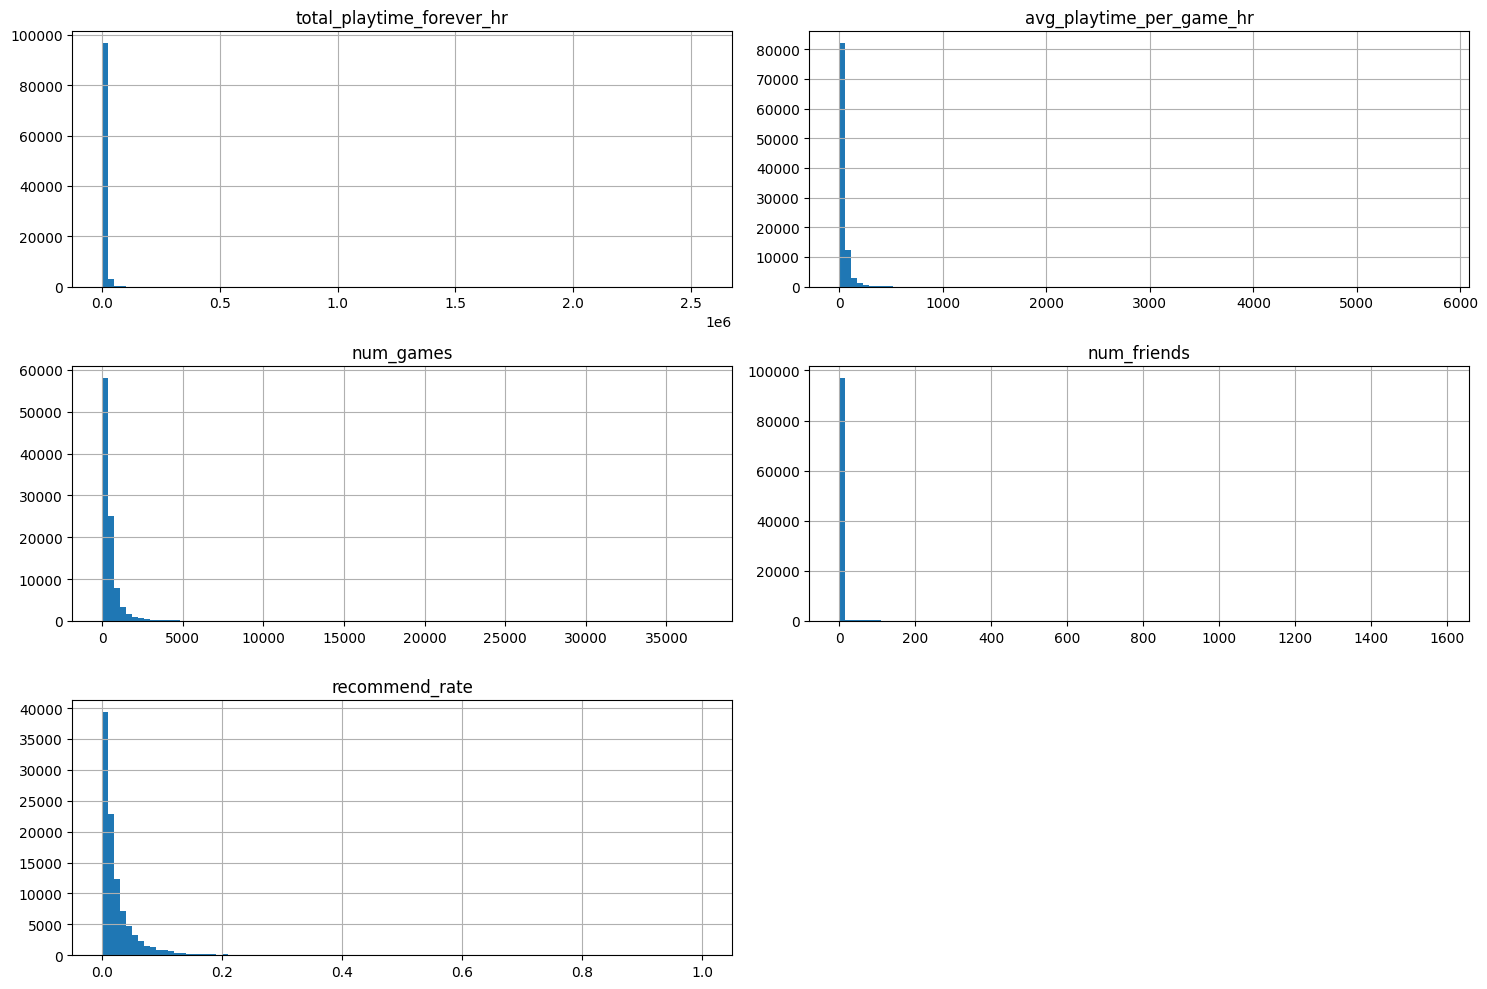

In [ ]:
cols = ['total_playtime_forever_hr', 'avg_playtime_per_game_hr', 'num_games', 'num_friends', 'recommend_rate']
df[cols].hist(bins=100, figsize=(15, 10))
plt.tight_layout()
plt.show()

Строим тепловую карту корреляции

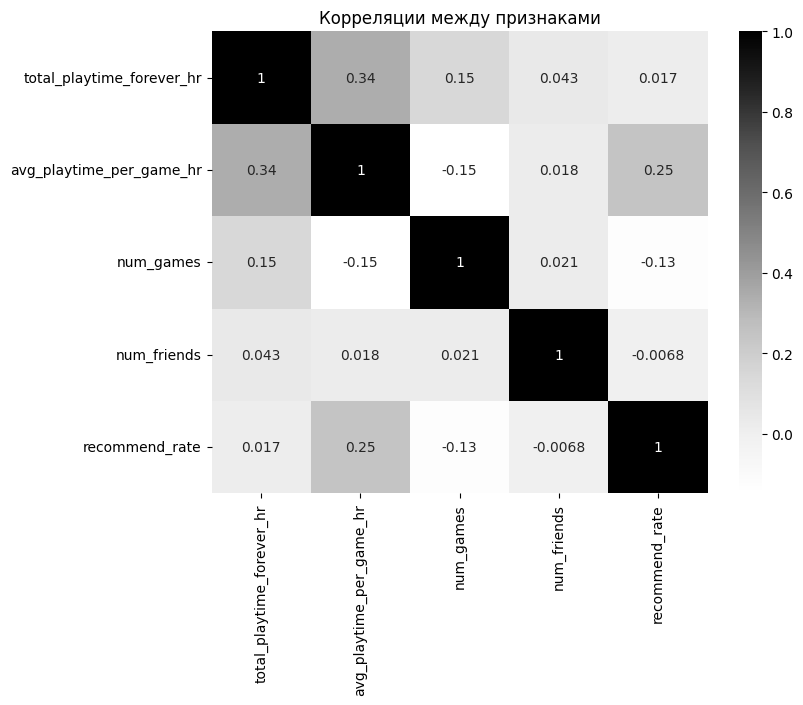

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(df[cols].corr(), annot=True, cmap='Greys')
plt.title("Корреляции между признаками")
plt.show()

5. Фильтруем выбросы

In [ ]:
low = df[['num_games', 'total_playtime_forever_hr', 'total_playtime_2weeks_hr', 'avg_playtime_per_game_hr']].quantile(0.0)
high = df[['num_games', 'total_playtime_forever_hr', 'total_playtime_2weeks_hr', 'avg_playtime_per_game_hr']].quantile(0.97)
mask = (df[['num_games', 'total_playtime_forever_hr', 'total_playtime_2weeks_hr', 'avg_playtime_per_game_hr']] >= low) & (df[['num_games', 'total_playtime_forever_hr', 'total_playtime_2weeks_hr', 'avg_playtime_per_game_hr']] <= high)
df_filtered = df[mask.all(axis=1)]

In [ ]:
df_filtered

,num_friends,num_games,recommend_rate,total_playtime_forever_hr,total_playtime_2weeks_hr,avg_playtime_per_game_hr
0,397,857,0.005834,24575.316667,63.833333,28.675982
1,0,352,0.005682,12821.783333,0.000000,36.425521
2,82,386,0.038860,1091.016667,26.883333,2.826468
3,395,160,0.006250,0.000000,0.000000,0.000000
4,200,221,0.009050,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
99995,0,1101,0.004541,11188.850000,31.916667,10.162443
99996,0,1318,0.000759,9451.216667,28.883333,7.170878
99997,0,522,0.040230,19194.566667,53.700000,36.771201
99998,0,163,0.012270,4393.366667,0.000000,26.953170


In [ ]:
df_filtered.describe()

,num_friends,num_games,recommend_rate,total_playtime_forever_hr,total_playtime_2weeks_hr,avg_playtime_per_game_hr
count,90219.000000,90219.000000,90219.000000,90219.000000,90219.000000,90219.000000
mean,3.792948,421.658642,0.025262,8099.228168,27.506978,31.246693
std,28.913859,373.783940,0.036709,5626.399568,31.989950,29.704419
min,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,171.000000,0.006211,4036.833333,0.133333,10.736704
50%,0.000000,307.000000,0.013793,7329.616667,16.266667,22.898205
75%,0.000000,536.000000,0.029703,11419.466667,43.591667,42.327963
max,1304.000000,2246.000000,0.796875,26457.766667,148.600000,164.749432


Оцениваем распределение после усечения выборки

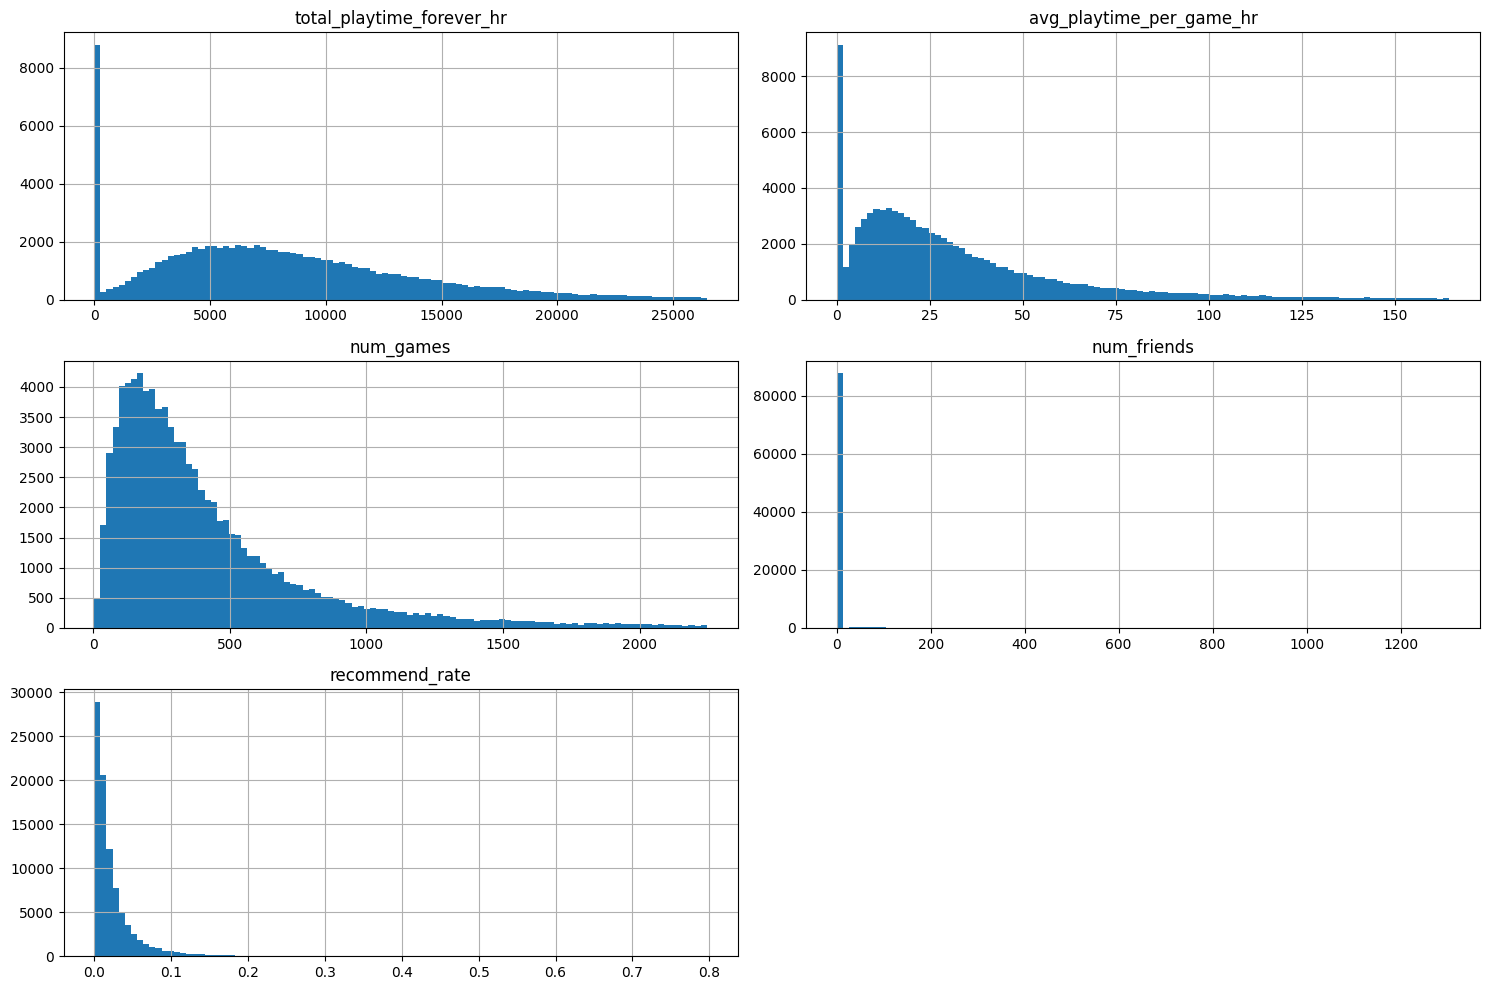

In [ ]:
cols = ['total_playtime_forever_hr', 'avg_playtime_per_game_hr', 'num_games', 'num_friends', 'recommend_rate']
df_filtered[cols].hist(bins=100, figsize=(15, 10))
plt.tight_layout()
plt.show()

6. Кластеризация пользователей

In [ ]:
# Масштабируем
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_filtered)

Определим оптимальное количество кластеров (по методу локтя)

In [ ]:
inertia = []
for k in range(1, 10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

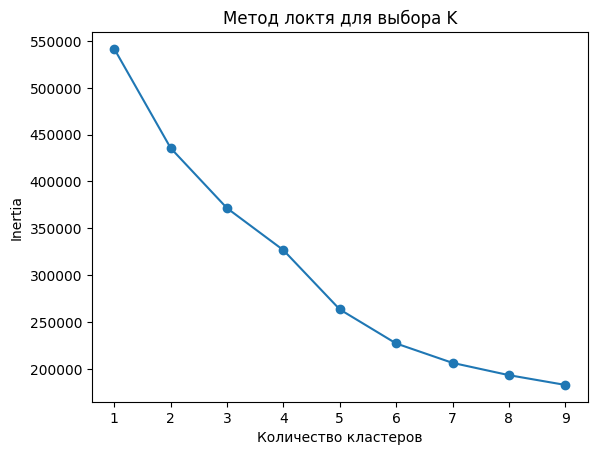

In [ ]:
plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel("Количество кластеров")
plt.ylabel("Inertia")
plt.title("Метод локтя для выбора K")
plt.show()

7. Построение кластеров и визуализация

In [ ]:
df_clust = df_filtered
# Кластеризация
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

df_clust["cluster"] = clusters

# PCA для визуализации
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

df_clust["pca_1"] = components[:, 0]
df_clust["pca_2"] = components[:, 1]

/tmp/ipython-input-1430558245.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clust["cluster"] = clusters
/tmp/ipython-input-1430558245.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clust["pca_1"] = components[:, 0]
/tmp/ipython-input-1430558245.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Визуализация кластеров

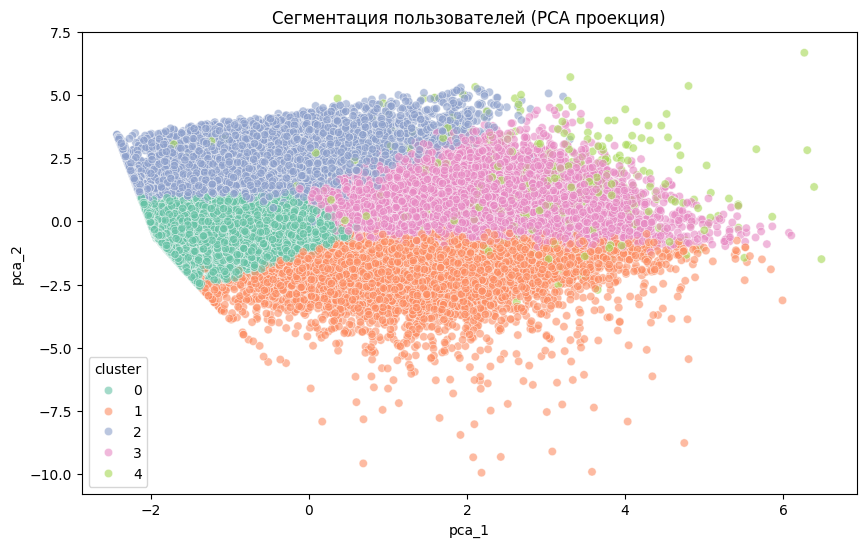

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_clust, x="pca_1", y="pca_2", hue="cluster", palette="Set2", alpha=0.6)
plt.title("Сегментация пользователей (PCA проекция)")
plt.show()

Расчет коэффициента силуэта, для проверки количества кластеров

In [ ]:
df_clust['kmeans_cluster'] = kmeans.fit_predict(X_scaled)

In [27]:
from sklearn.metrics import silhouette_score
silhouette_score(X_scaled, kmeans.labels_)

np.float64(0.30481158714242657)

8. Анализ кластеров

Агрегация и анализ средних значений по каждому кластеру

In [28]:
df_clusters = df_clust.groupby('kmeans_cluster')[['num_friends', 'num_games', 'recommend_rate','total_playtime_forever_hr', 'avg_playtime_per_game_hr']].mean()

In [29]:
df_clusters

,num_friends,num_games,recommend_rate,total_playtime_forever_hr,avg_playtime_per_game_hr
kmeans_cluster,,,,,
0,0.760411,314.603128,0.019670,4747.946263,18.670888
1,0.687326,143.452160,0.064363,9459.277921,79.679079
2,1.015539,1230.102943,0.013048,9512.009998,8.432505
3,1.875308,428.839917,0.018495,13653.347740,38.532474
4,228.043836,441.320548,0.023497,10790.802268,36.983580


Построение столбчатых и коробчатых диаграмм для каждого параметра

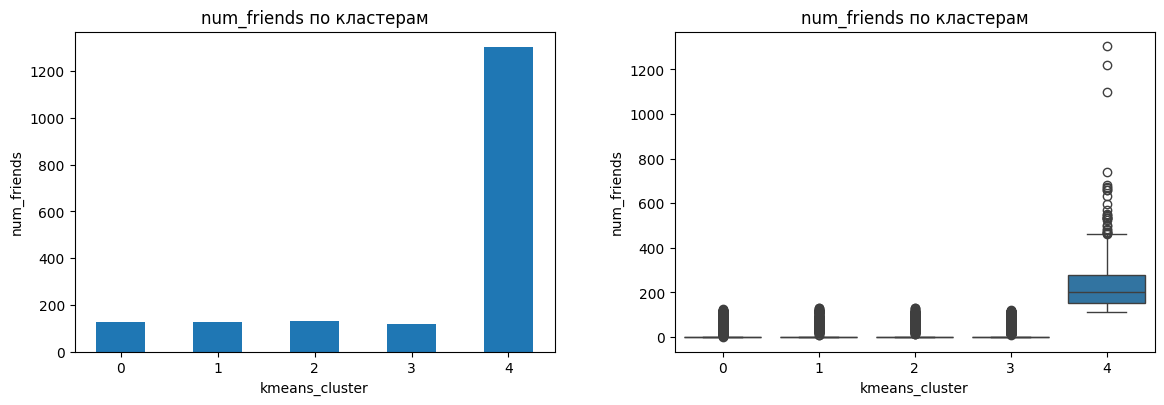

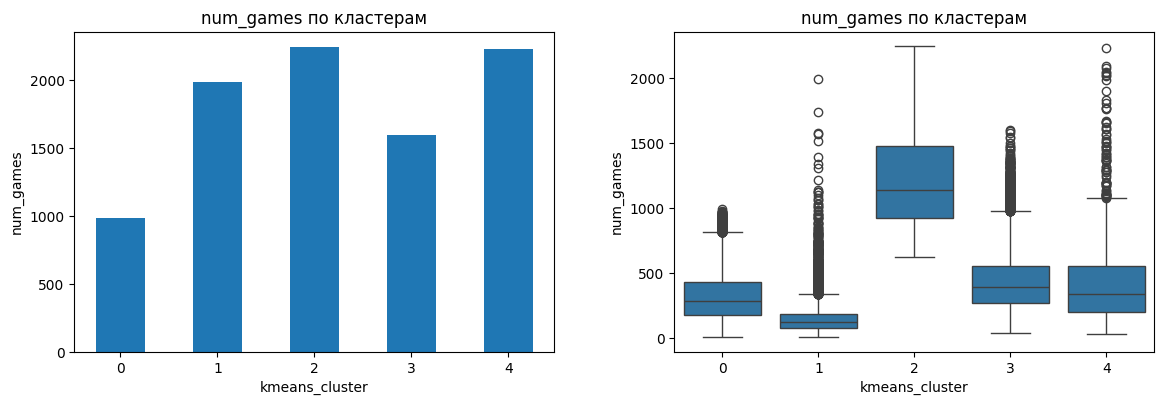

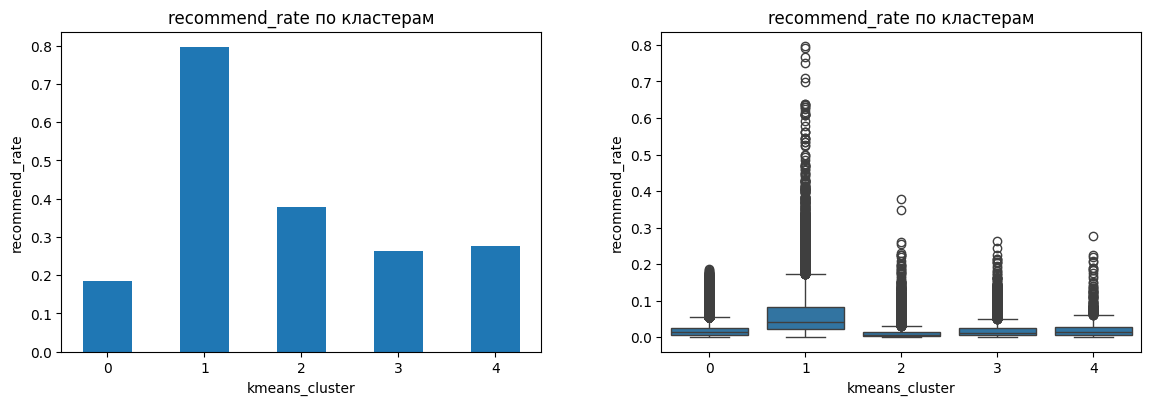

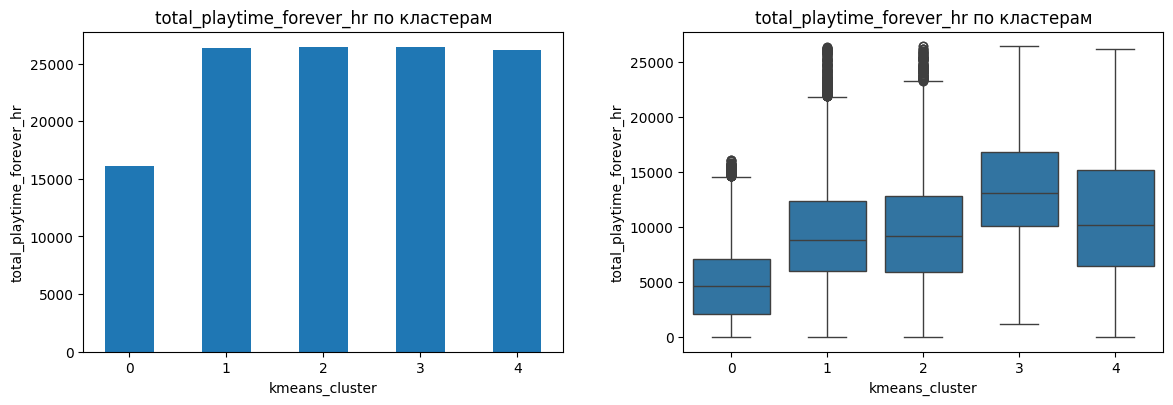

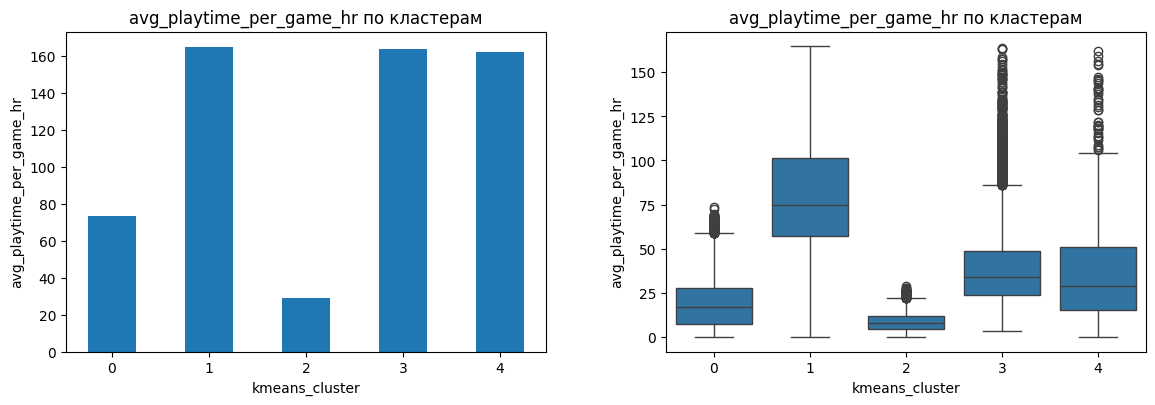

In [30]:
features = ['num_friends', 'num_games', 'recommend_rate', 'total_playtime_forever_hr', 'avg_playtime_per_game_hr']

for col in features:
    fig = plt.figure(figsize=(6, 4))

    ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    ax2 = fig.add_axes([1.1, 0.1, 0.8, 0.8])

    ax1.bar(x=df_clust['kmeans_cluster'], height=df_clust[col], width = 0.5)
    sns.boxplot(x=df_clust['kmeans_cluster'], y=df_clust[col], ax=ax2)

    ax1.set_xlabel('kmeans_cluster')
    ax1.set_ylabel(col)
    ax1.set_title(f'{col} по кластерам')

    ax2.set_xlabel('kmeans_cluster')
    ax2.set_ylabel(col)
    ax2.set_title(f'{col} по кластерам')

    plt.show()

Визуализация размера сегментов

In [31]:
df_clust

,num_friends,num_games,recommend_rate,total_playtime_forever_hr,total_playtime_2weeks_hr,avg_playtime_per_game_hr,cluster,pca_1,pca_2,kmeans_cluster
0,397,857,0.005834,24575.316667,63.833333,28.675982,4,3.797709,3.295371,4
1,0,352,0.005682,12821.783333,0.000000,36.425521,0,0.085683,-0.013415,0
2,82,386,0.038860,1091.016667,26.883333,2.826468,0,-0.930805,0.062708,0
3,395,160,0.006250,0.000000,0.000000,0.000000,4,-0.362175,0.636341,4
4,200,221,0.009050,0.000000,0.000000,0.000000,4,-1.146205,0.170416,4
...,...,...,...,...,...,...,...,...,...,...
99995,0,1101,0.004541,11188.850000,31.916667,10.162443,2,-0.200313,1.971430,2
99996,0,1318,0.000759,9451.216667,28.883333,7.170878,2,-0.558806,2.345098,2
99997,0,522,0.040230,19194.566667,53.700000,36.771201,3,1.779586,0.703041,3
99998,0,163,0.012270,4393.366667,0.000000,26.953170,0,-0.951514,-0.709198,0


In [32]:
df_clust['kmeans_cluster'].value_counts()/len(df_clust)*100

,count
kmeans_cluster,
0,49.746727
3,22.925326
1,14.700894
2,11.413339
4,1.213713


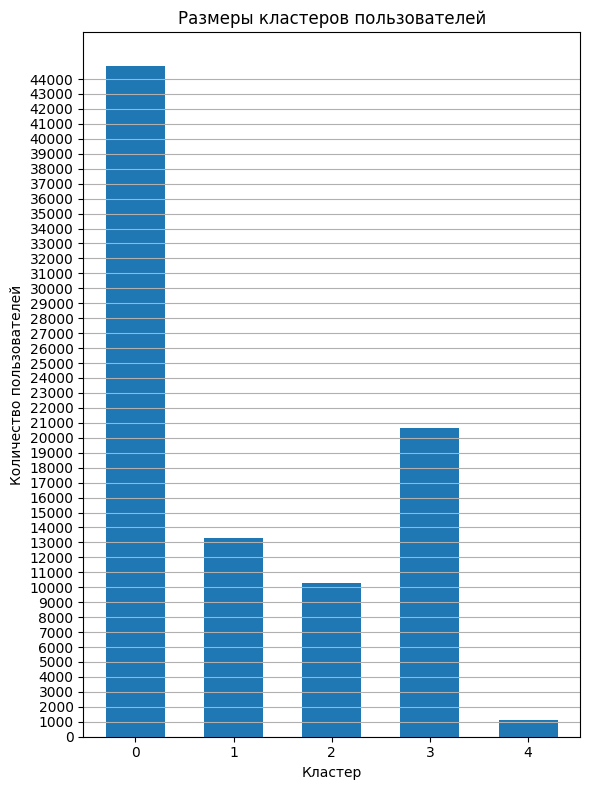

In [33]:
plt.figure(figsize=(6, 8))
plt.bar(x=df_clust['kmeans_cluster'].value_counts().index, height=df_clust['kmeans_cluster'].value_counts().values, width=0.6)
plt.title('Размеры кластеров пользователей')
plt.xlabel('Кластер')
plt.ylabel('Количество пользователей')
plt.grid(axis='y')
plt.tight_layout()
plt.yticks(np.arange(0, 45000, 1000))
plt.show()

Кластер 0 - Стандартные пользователи, казуалы. Немного друзей, среднее количество игр, среднее количество рекомендаций, мало общего и среднего игрового времени.

Кластер 1 - Преданные любимым играм и увлеченные геймеры. Мало друзей и игр, большой число рекомендаций, средний показатель общего игрового времени и большое среднее время в игре.

Кластер 2 - Коллекционеры игр. Среднее количество друзей и показатель общего игрового времени, огромная библиотека игр, наименьшие показатели рекомендация и среднего игрового времени.

Кластер 3 - Старые активные игроки. Среднее количество друзей, игр и среднего игрового времени, небольшой показатель рекомендаций, самый высокий показатель времени в игре.

Кластер 4 - Социальные игроки/Продавцы игр, предметов. Огромное количество друзей, средние показатели количества игр, рекомендаций и времени.

Стандартные игроки составляют самый многочисленный пласт пользователей стим - 50%. Социальные игроки/Продавцы игр, предметов - самые немногочисленные(1%), старые активные пользователи составляют (23%). Игроки увлеченные парой игр и Коллекционеры составляют 15%  и 11% соотвественно.

Полученная кластеризация может использоваться как основа для построения персонализированных рекомендаций игр, оптимизации маркетинговых стратегий или анализа поведения групп пользователей.